In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
from PIL import Image

folder_path = r"C:\Users\Admin\PythonScripts\RohitPSACM"

#define transforms
#define data augmentations

dataTransforms = {
    "train": transforms.Compose([
      transforms.Resize(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    "val": transforms.Compose([
      transforms.Resize(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),


    "test" : transforms.Compose([
      transforms.Resize(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

imgDatasets = {x: datasets.ImageFolder(os.path.join(folder_path, x), dataTransforms[x]) for x in ['train', 'val', 'test'] }

dataloaders = {x: torch.utils.data.DataLoader(imgDatasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(imgDatasets[x]) for x in ['train', 'val', 'test']}
print(dataset_sizes)

class_names = imgDatasets['test'].classes
class_names



{'train': 805, 'val': 383, 'test': 180}


['Pepe', 'not_pepe']

In [5]:
from torch.utils.data import DataLoader

trainLoss = dict([])
trainAcc = dict([])
valLoss = dict([])
valAcc = dict([])
testLoss = dict([])
testAcc = dict([])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Set data directories
data_dir = folder_path
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Define model architecture (using pre-trained ResNet18)
model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: Pepe and Non-Pepe
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

#num_epochs = 15

# Training function
def train_model(model, criterion, optimizer, num_epochs = 15):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                trainLoss[epoch + 1] = float(epoch_loss)
                trainAcc[epoch + 1] = float(epoch_acc)

            elif phase == 'val':
                valLoss[epoch + 1] = float(epoch_loss)
                valAcc[epoch + 1] = float(epoch_acc)

            elif phase == 'test':
                testLoss[epoch + 1] = float(epoch_loss)
                testAcc[epoch + 1] = float(epoch_acc)


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Train the model
train_model(model, criterion, optimizer, num_epochs=15)

# Save the trained model
torch.save(model.state_dict(), 'PepeOrNotclassifier.pth')

print("Train Losses: ", trainLoss)
print("Train Accuracy: ", trainAcc)
print("Validation Losses: ", valLoss)
print("Validation Accuracy: ", valAcc)
print("Testing Losses: ", testLoss)
print("Testing Accuracy: ", testAcc)

Epoch 1/15
----------
train Loss: 0.4573 Acc: 0.7801
val Loss: 0.1602 Acc: 0.9739
test Loss: 0.2159 Acc: 0.9500
Epoch 2/15
----------
train Loss: 0.3281 Acc: 0.8621
val Loss: 0.1045 Acc: 0.9843
test Loss: 0.1570 Acc: 0.9667
Epoch 3/15
----------
train Loss: 0.3220 Acc: 0.8596
val Loss: 0.0776 Acc: 0.9843
test Loss: 0.1184 Acc: 0.9889
Epoch 4/15
----------
train Loss: 0.2612 Acc: 0.8907
val Loss: 0.0653 Acc: 0.9896
test Loss: 0.1045 Acc: 0.9667
Epoch 5/15
----------
train Loss: 0.2688 Acc: 0.8783
val Loss: 0.0694 Acc: 0.9843
test Loss: 0.1042 Acc: 0.9611
Epoch 6/15
----------
train Loss: 0.2337 Acc: 0.9217
val Loss: 0.0375 Acc: 0.9974
test Loss: 0.0751 Acc: 0.9833
Epoch 7/15
----------
train Loss: 0.2466 Acc: 0.9031
val Loss: 0.0463 Acc: 0.9922
test Loss: 0.0723 Acc: 0.9778
Epoch 8/15
----------
train Loss: 0.2264 Acc: 0.9081
val Loss: 0.0417 Acc: 0.9896
test Loss: 0.0694 Acc: 0.9833
Epoch 9/15
----------
train Loss: 0.2196 Acc: 0.9155
val Loss: 0.0313 Acc: 0.9948
test Loss: 0.0582 Acc:

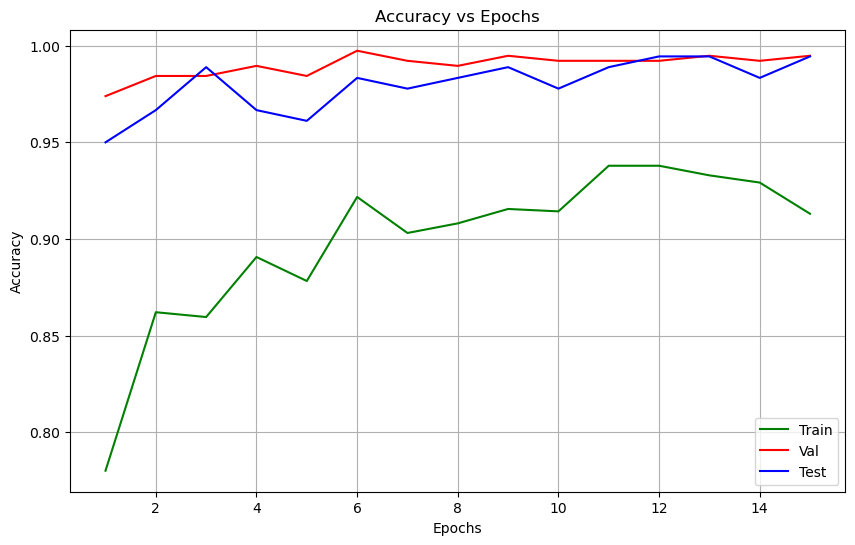

In [4]:
import matplotlib.pyplot as plt

trainAcc = {1: 0.7801242236024845, 2: 0.8621118012422361, 3: 0.8596273291925466, 4: 0.8906832298136645, 5: 0.8782608695652174, 6: 0.9217391304347826, 7: 0.9031055900621118, 8: 0.9080745341614906, 9: 0.915527950310559, 10: 0.9142857142857143, 11: 0.937888198757764, 12: 0.937888198757764, 13: 0.9329192546583851, 14: 0.929192546583851, 15: 0.9130434782608695}

valAcc = {1: 0.9738903394255874, 2: 0.9843342036553525, 3: 0.9843342036553525, 4: 0.9895561357702349, 5: 0.9843342036553525, 6: 0.9973890339425587, 7: 0.9921671018276762, 8: 0.9895561357702349, 9: 0.9947780678851175, 10: 0.9921671018276762, 11: 0.9921671018276762, 12: 0.9921671018276762, 13: 0.9947780678851175, 14: 0.9921671018276762, 15: 0.9947780678851175}

testAcc = {1: 0.95, 2: 0.9666666666666667, 3: 0.9888888888888889, 4: 0.9666666666666667, 5: 0.9611111111111111, 6: 0.9833333333333333, 7: 0.9777777777777777, 8: 0.9833333333333333, 9: 0.9888888888888889, 10: 0.9777777777777777, 11: 0.9888888888888889, 12: 0.9944444444444445, 13: 0.9944444444444445, 14: 0.9833333333333333, 15: 0.9944444444444445}

# Plotting
plt.figure(figsize=(10, 6))

# Plot dictionary 1 (green)
plt.plot(list(trainAcc.keys()), list(trainAcc.values()), color='green', label='Train')

# Plot dictionary 2 (red)
plt.plot(list(valAcc.keys()), list(valAcc.values()), color='red', label='Val')

# Plot dictionary 3 (blue)
plt.plot(list(testAcc.keys()), list(testAcc.values()), color='blue', label='Test')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

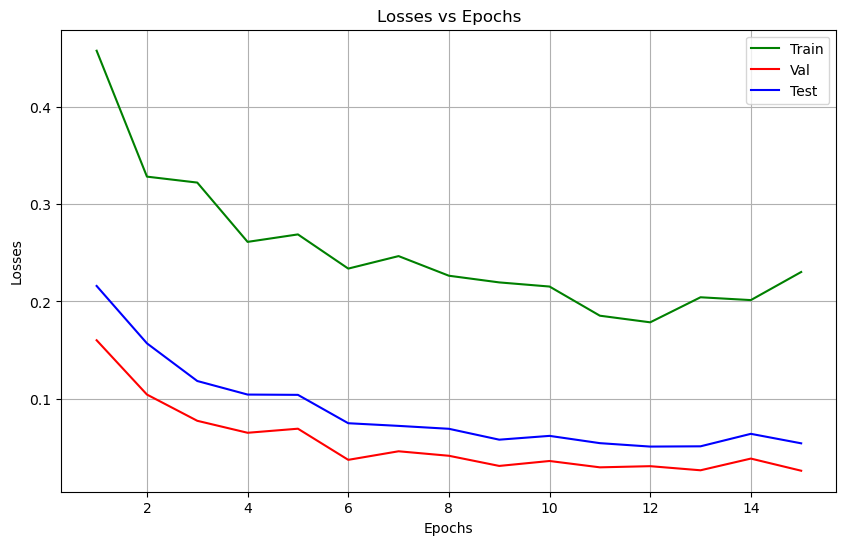

In [3]:
import matplotlib.pyplot as plt

trainLoss = {1: 0.4573322451077633, 2: 0.3281181998689723, 3: 0.3220192968937921, 4: 0.26117140877506007, 5: 0.26883446382624765, 6: 0.23374972321694681, 7: 0.24657874999116666, 8: 0.22642975984060246, 9: 0.21958280835555208, 10: 0.2153321602005766, 11: 0.18541120221803647, 12: 0.17861969333188318, 13: 0.20432232266627484, 14: 0.2014212148183066, 15: 0.2302630500671286}
valLoss = {1: 0.16022707963503371, 2: 0.10449245144605793, 3: 0.07756616624057604, 4: 0.06526970895804834, 5: 0.0694475786337342, 6: 0.037496280756732815, 7: 0.046284196305018184, 8: 0.041677306873077045, 9: 0.03125068194210996, 10: 0.036313555227694715, 11: 0.029807128515532216, 12: 0.030994055844969833, 13: 0.02678205530212672, 14: 0.03879217100366172, 15: 0.026331786110063447}
testLoss = {1: 0.2159429448346297, 2: 0.15703418337636524, 3: 0.11840118198759025, 4: 0.10448448416880435, 5: 0.10418372705785764, 6: 0.07506769837087227, 7: 0.07234446491218276, 8: 0.06935483535958661, 9: 0.058189246260250606, 10: 0.06209178001930316, 11: 0.054622131965071374, 12: 0.05110455764871505, 13: 0.05137942094976703, 14: 0.0641909837955609, 15: 0.0544476740139847}

# Three sample dictionaries (replace these with your actual dictionaries)

# Plotting
plt.figure(figsize=(10, 6))

# Plot dictionary 1 (green)
plt.plot(list(trainLoss.keys()), list(trainLoss.values()), color='green', label='Train')

# Plot dictionary 2 (red)
plt.plot(list(valLoss.keys()), list(valLoss.values()), color='red', label='Val')

# Plot dictionary 3 (blue)
plt.plot(list(testLoss.keys()), list(testLoss.values()), color='blue', label='Test')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Losses vs Epochs')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [4]:
from torch.utils.data import DataLoader

trainLoss = dict([])
trainAcc = dict([])
valLoss = dict([])
valAcc = dict([])
testLoss = dict([])
testAcc = dict([])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Set data directories
data_dir = folder_path
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Define model architecture (using pre-trained ResNet18)
model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: Pepe and Non-Pepe
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)

#num_epochs = 15

# Training function
def train_model(model, criterion, optimizer, num_epochs = 15):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                trainLoss[epoch + 1] = float(epoch_loss)
                trainAcc[epoch + 1] = float(epoch_acc)

            elif phase == 'val':
                valLoss[epoch + 1] = float(epoch_loss)
                valAcc[epoch + 1] = float(epoch_acc)

            elif phase == 'test':
                testLoss[epoch + 1] = float(epoch_loss)
                testAcc[epoch + 1] = float(epoch_acc)


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Train the model
train_model(model, criterion, optimizer, num_epochs=15)

# Save the trained model
torch.save(model.state_dict(), 'PepeOrNotclassifier.pth')

print("Train Losses: ", trainLoss)
print("Train Accuracy: ", trainAcc)
print("Validation Losses: ", valLoss)
print("Validation Accuracy: ", valAcc)
print("Testing Losses: ", testLoss)
print("Testing Accuracy: ", testAcc)

Epoch 1/15
----------
train Loss: 1.0547 Acc: 0.5925
val Loss: 1.0447 Acc: 0.6736
test Loss: 1.3798 Acc: 0.5556
Epoch 2/15
----------
train Loss: 0.7012 Acc: 0.5975
val Loss: 1.8272 Acc: 0.6632
test Loss: 1.1450 Acc: 0.6278
Epoch 3/15
----------
train Loss: 0.6701 Acc: 0.6075
val Loss: 0.5816 Acc: 0.7520
test Loss: 0.7311 Acc: 0.6722
Epoch 4/15
----------
train Loss: 0.5198 Acc: 0.7491
val Loss: 0.7393 Acc: 0.8695
test Loss: 0.8094 Acc: 0.7944
Epoch 5/15
----------
train Loss: 0.4827 Acc: 0.7876
val Loss: 0.2646 Acc: 0.9034
test Loss: 0.3963 Acc: 0.8444
Epoch 6/15
----------
train Loss: 0.4849 Acc: 0.7677
val Loss: 0.3997 Acc: 0.8747
test Loss: 0.6159 Acc: 0.8333
Epoch 7/15
----------
train Loss: 0.4670 Acc: 0.7876
val Loss: 0.3612 Acc: 0.9164
test Loss: 0.5900 Acc: 0.8611
Epoch 8/15
----------
train Loss: 0.4501 Acc: 0.7888
val Loss: 1.1018 Acc: 0.8042
test Loss: 1.3816 Acc: 0.7667
Epoch 9/15
----------
train Loss: 0.4470 Acc: 0.7888
val Loss: 1.3760 Acc: 0.3786
test Loss: 1.3222 Acc: